# Fitting Generalized Linear Models (GLMs) on neural data from hippocampus

In this tutorial, we will fit Generalized Linear Models (GLMs) to data from neurons recorded in hippocampus.

(TODO add some details about the dataset)

Adapted from https://github.com/pillowlab/GLMspiketraintutorial_python/blob/main/tutorial1_PoissonGLM.ipynb

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import cebra
import cebra.datasets
from scipy.io import loadmat
import scipy.linalg

## Data loading

In [31]:
from week5_utils import HippocampusDataset

data = HippocampusDataset()
data.all_spikes_binned.shape, data.position.shape, data.num_neurons

((10178, 120), (10178,), 120)

In [32]:
print(data.get_neuron_spikes(52).shape) # get spikes for neuron with index 52

(10178,)


In [33]:
print(data.position.shape) # The position of the animal, as a 1D timeseries

(10178,)


In [34]:
print(data.direction.shape) # The direction (left or right) of the animal, as a 1D timeseries

(10178,)


In [35]:
print(data.sampling_rate_hz) # The sampling rate, in Hz

100.0


In [36]:
print(data.all_spikes_binned.shape) # An array containing all spike counts for all neurons

print(len(data), data.num_neurons) # Information about the length and number of neurons in the dataset

(10178, 120)
10178 120


## Data Visualization

We first visualize the data.

**Exercise: Adapt the code and compare the outputs of different neurons!*

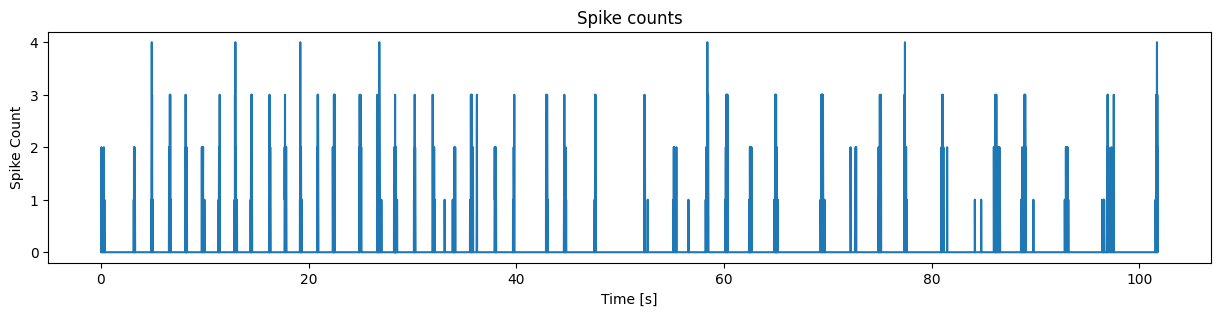

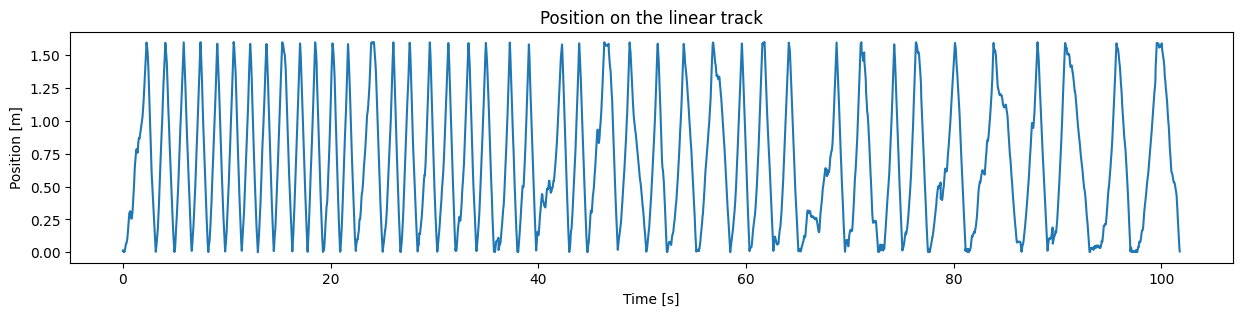

In [37]:
plt.figure(figsize=(15,3))
plt.plot(data.time, data.get_neuron_spikes(51))
plt.title("Spike counts")
plt.xlabel("Time [s]")
plt.ylabel("Spike Count")
plt.show()

plt.figure(figsize=(15,3))
plt.plot(data.time, data.position)
plt.title("Position on the linear track")
plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.show()

### Tuning curves

To explore the dataset, we plot the tuning curves (at which point in location does each neuron fire?) for all 120 neurons in the dataset

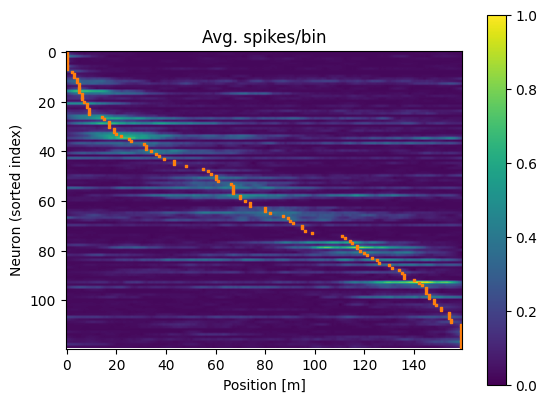

In [38]:
import scipy.signal

stim = data.position
neural = data.all_spikes_binned

counts, bins = np.histogram(data.position, bins = 160, range = (0,1.6))
stim_bin_idx = np.digitize(data.position, bins, right = False) - 1

avg = np.zeros((160, 120))
for i in range(160):
    avg[i, :] = neural[stim_bin_idx==i,:].mean(0)

# We smooth the data
avg = scipy.signal.savgol_filter(avg, axis = 0, window_length=11, polyorder=2)

max_bin = avg.argmax(axis = 0)
neuron_index = np.argsort(max_bin)

plt.title("Avg. spikes/bin")
plt.imshow(avg[:, neuron_index].T)
plt.scatter(max_bin[neuron_index], np.arange(120), marker='s', c = 'C1', s = 1)
plt.colorbar()
plt.xlabel("Position [m]")
plt.ylabel("Neuron (sorted index)")
plt.show()

## Design matrix

We will now construct the design matrix for the model. The model should consider outputs from different previous time-steps,

$$
y_t = x_t \theta_1 + x_{t-1} \theta_2 + \dots + x_{t-T} \theta_{T+1}
$$

To express this into a single matrix-vector product, we construct a vector containing all the $x_i$:

$$
\mathbf{x}_t = (x_t \dots x_{t-T})^\top
$$

and we re-arranges these vectors for every time step into a matrix.

Below is an example for such a matrix, with one $\mathbf{x}_t$ per row:

Text(0.5, 1.0, 'Design Matrix $X$')

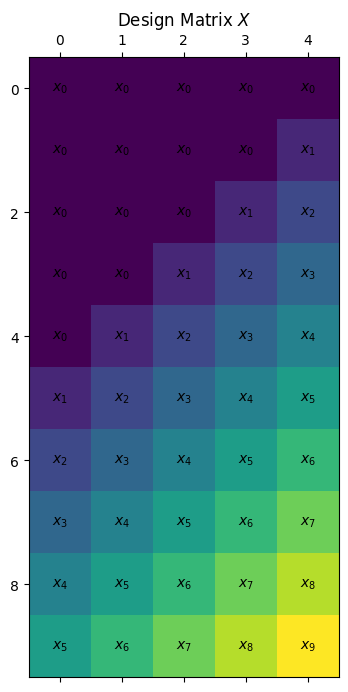

In [39]:
def build_design_matrix_ref(stim, filter_size):
    """For reference, this is a fast way to build the design matrix."""
    padded_stim = np.hstack((np.zeros(filter_size-1), stim))   # pad early bins of stimulus with zero
    design_mat = scipy.linalg.hankel(padded_stim[:-filter_size+1], stim[-filter_size:])
    return design_mat

# Here as an example stimulus we would like to convert into a design matrix
# For simplicity
stim = np.arange(10)

matrix = build_design_matrix_ref(stim, filter_size = 5)
plt.matshow(matrix)

for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        c = matrix[i, j]
        plt.gca().text(j, i, f"$x_{int(c)}$", va='center', ha='center')

plt.title("Design Matrix $X$")

**Exercise: Write some code that constructs a design matrix like the one you see above, using standard numpy functions!**

In [40]:
def build_design_matrix(stim, filter_size):
    pass

### START SOLUTION
def build_design_matrix(stim, filter_size):
    """Exercise: Build the design matrix manually.
    
    This is the solution!
    """
    padded_stim = np.pad(stim, (filter_size-1,0), mode = "constant", constant_values = 0.)
    design_mat = np.zeros((len(stim),filter_size))
    for j in np.arange(len(stim)):
        design_mat[j] = padded_stim[j:j+filter_size] # grab last 'nkt' bins of stmiulus and insert into this row
    return design_mat
### END SOLUTION

We can now also formally test if the function is correct, by running the code below.

In [41]:
def test_design_matrix(stim, filter_size):
    """A test that checks that the matrix construction is correct."""

    ours = build_design_matrix(stim, filter_size = filter_size)
    reference = build_design_matrix_ref(stim, filter_size = filter_size)

    # Check that the matrix construction is correct!
    assert ours.shape == (stim.shape[0], filter_size), f"{ours.shape} vs. {(stim.shape[0], filter_size)}"
    assert (ours == reference).all()

test_design_matrix(stim = np.arange(100), filter_size = 15)
test_design_matrix(stim = np.arange(4), filter_size = 3)

Let's now construct and visualize the design matrix on the real dataset:

<Figure size 1200x800 with 0 Axes>

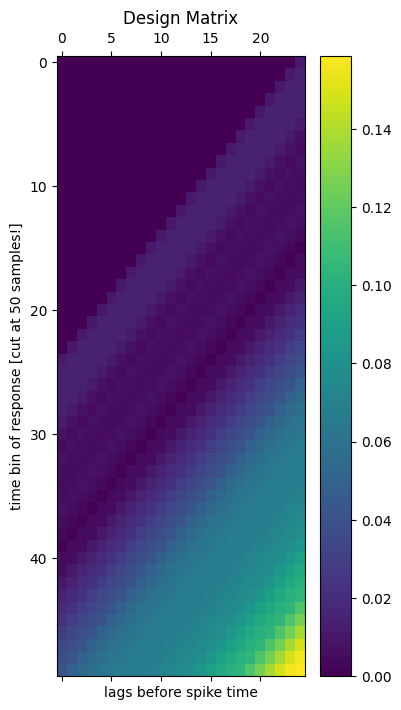

In [42]:
filter_size = 25
design_mat = build_design_matrix(data.position, filter_size=filter_size)
design_mat_ref = build_design_matrix_ref(data.position, filter_size=filter_size)
    
plt.figure(figsize=[12,8])
plt.matshow(design_mat[:50], aspect='auto')
plt.xlabel('lags before spike time')
plt.ylabel('time bin of response [cut at 50 samples!]')
plt.title("Design Matrix")
plt.colorbar()
plt.show();

In the visualization above, we cut the design matrix at 50 samples. We will now visualize the spike counts of a single neuron along with the design matrix containing all the regressors for our GLM model together.

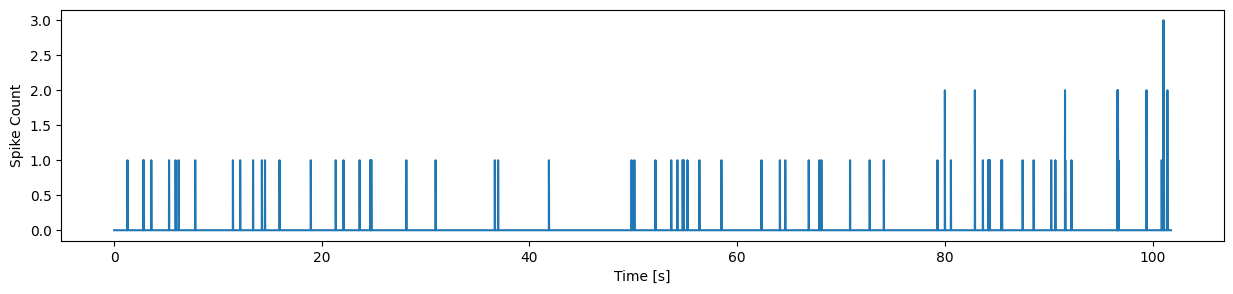

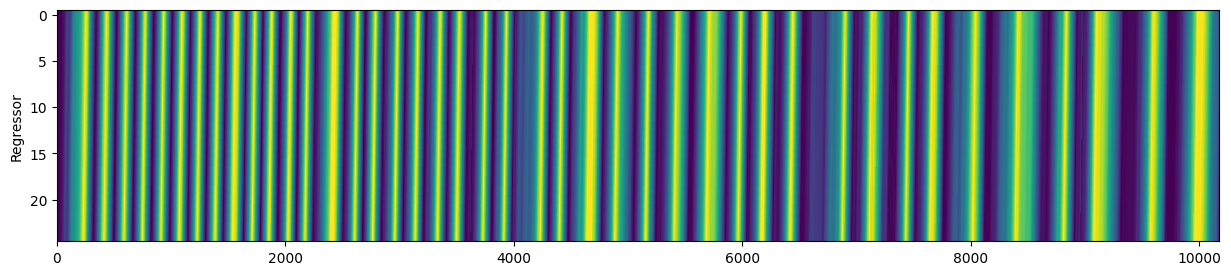

In [43]:
filter_size = 25
design_mat = build_design_matrix(stim = data.position, filter_size=filter_size)

plt.figure(figsize=(15,3))
plt.plot(data.time, neural[:,30])
plt.xlabel("Time [s]")
plt.ylabel("Spike Count")
plt.show()

plt.figure(figsize=(15,3))
plt.imshow(design_mat.T, aspect = "auto", interpolation="none")
plt.ylabel("Regressor")
plt.show()

## Fitting a linear model to the dataset

We now have a pre-processed dataset, consisting of the design matrix $X$, and a vector of output variables $\mathbf{y}$, which are the responses of a selected neuron.

... TODO explain the linear regression / gaussian glm here ...

In [44]:
import sklearn.metrics

class LinearModel():

    def fit(self, X, y):
        # Write a function that fits the parameters of the linear model!
        self._params = ...

        y_pred = self.predict(X)
        self._score = sklearn.metrics.r2_score(y, y_pred)

        return self

    def predict(self, design_mat):
        return self.constant_params + design_mat @ self.filter_params

    def score(self):
        return self._score

    @property
    def filter_params(self):
        return ...

    @property
    def constant_params(self):
        return ...


### SOLUTION
class LinearModel():

    def fit(self, X, y):
        Xb = np.hstack((np.ones((len(X),1)), X))
        self._params = np.linalg.inv(Xb.T @ Xb) @ (Xb.T @ y)

        y_pred = self.predict(X)
        self._score = sklearn.metrics.r2_score(y, y_pred)

        return self

    def predict(self, design_mat):
        return self.constant_params + design_mat @ self.filter_params

    def score(self):
        return self._score

    @property
    def filter_params(self):
        return self._params[1:]

    @property
    def constant_params(self):
        return self._params[0]
### END SOLUTION

Let's test our implementation on some synthetic data.

In [45]:
def test_linear_model():

    X = np.random.normal(size=(10000, 10))
    y = (X @ np.random.normal(size=(10, 1))).squeeze()

    assert np.isclose(LinearModel().fit(X, y).score(), 1.0)

test_linear_model()

We can now apply our implementation to real data:

In [46]:
X = build_design_matrix(stim = data.position, filter_size=25)
y = data.get_neuron_spikes(51)
print(X.shape, y.shape)

model = LinearModel().fit(X, y)
print("Score", model.score())

(10178, 25) (10178,)
Score 0.08755237390926196


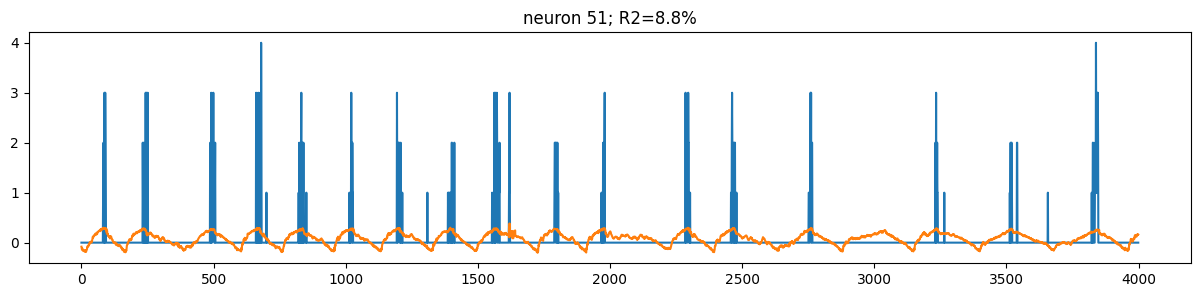

In [47]:
prediction = model.predict(X)
neuron_id = 51

plt.figure(figsize=(15,3))
plt.plot(y[2000:6000])
plt.plot(prediction[2000:6000])
plt.title(f"neuron {neuron_id}; R2={model.score()*100:.1f}%")
plt.show()

We can observe that the fit is not very good --- this is because we used a *linear* link function, and assumed a Gaussian distribution on the outputs.
The assumptions do not reflect our original data (binned spike counts) particularly well (although the general locations of spikes is captured by the predictions above).
In the next section, we extend our model, and use a non-linear link function, along with a Possion distribution.

## GLM fitting with `statsmodels`

We will now fit GLMs using the `statsmodels` python library. The documentation can be found here: https://www.statsmodels.org/stable/glm.html

The components of the GLM are:
- the input variables: This is the design matrix we constructed in the previous step. The input has shape `timesteps, num_regressors`. The variables are also called *exogenous* variables, and abbreviated as `exog` in `statsmodels`.
- the output variables we would like to model: These are the binned spiking rates of the neuron we would like to fit. The output has shape `timesteps,` in our case (it is also possible to fit multivariate outputs, but we won't cover this during this tutorial). These variables are also called *endogenous* variables, and abbreviated as `endog` in `statsmodels`.
- the distribution to model, and the corresponding link function. In our case, we would like to fit a Poisson variable, and use a `log` link function. More details [here](https://www.statsmodels.org/stable/generated/statsmodels.genmod.families.family.Poisson.html#statsmodels.genmod.families.family.Poisson).

In [48]:
import statsmodels.api as sm

class GLMModel():
    """The class for our GLM model.
    
    We split the functionality into different parts:
    - fitting the model
    - computing the goodness of fit (the pseudo-R2)
    - making predictions on the dataset
    """

    def __init__(self):
        self.link_function = sm.families.links.Log()
        self.family = sm.families.Poisson(link = self.link_function)

    def fit(self, design_matrix, spikes):
        design_mat_offset = np.hstack((np.ones((len(design_matrix),1)), design_matrix))
        self._model = sm.GLM(
            endog=spikes,
            exog=design_mat_offset,
            family=self.family
        )
        self._results = self._model.fit(max_iter=100, tol=1e-6, tol_criterion='params')

    def predict(self, design_mat):
        return np.exp(self.constant_params + design_mat @ self.filter_params)

    def score(self):
        return self._results.pseudo_rsquared(kind='mcf') 

    @property
    def filter_params(self):
        return self._results.params[1:]

    @property
    def constant_params(self):
        return self._results.params[0]


glm = GLMModel()
glm.fit(design_mat, data.get_neuron_spikes(51))
print("Score", glm.score())

Score 0.4702026044553036


We can now fit GLMs on the full dataset!

In [49]:
import tqdm

prediction = np.zeros_like(data.all_spikes_binned)
filters = []
r2 = np.zeros(neural.shape[1])

r2[:] = float("nan")
prediction[:] = float("nan")

glm = GLMModel()

for neuron_id in tqdm.tqdm(range(data.num_neurons)):
    try:
        glm.fit(design_mat, data.get_neuron_spikes(neuron_id))
    except ValueError:
        print(f"Error fitting neuron {neuron_id}. Skipping")
        continue
    r2[neuron_id] = glm.score()
    prediction[:,neuron_id] = glm.predict(design_mat)

  0%|          | 0/120 [00:00<?, ?it/s]

 32%|███▎      | 39/120 [00:04<00:11,  6.81it/s]/Users/steffen.schneider/.pyenv/versions/3.10.13/envs/cebra/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
 35%|███▌      | 42/120 [00:04<00:07,  9.87it/s]

Error fitting neuron 39. Skipping


100%|██████████| 120/120 [00:12<00:00,  9.65it/s]


### Results overview (histogram of pseudo-R2 values)

To get an overview, we plot the pseudo-R2 values of all neurons across the dataset.

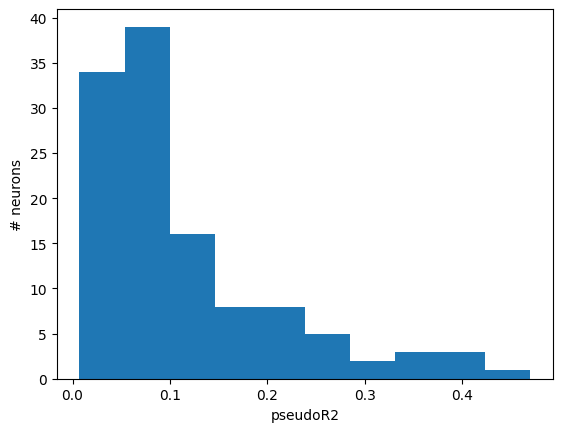

In [50]:
plt.hist(r2)
plt.ylabel("# neurons")
plt.xlabel("pseudoR2")
plt.show()

Next, we visualize the predictions for the two best-fitted and the two worst-fitted neurons.

51


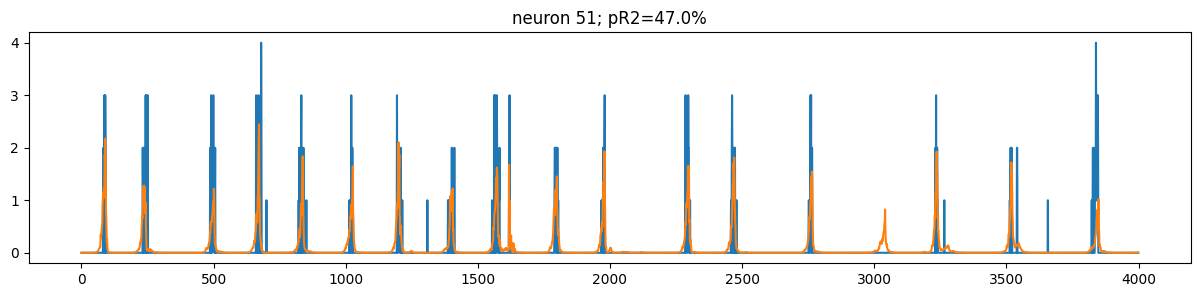

84


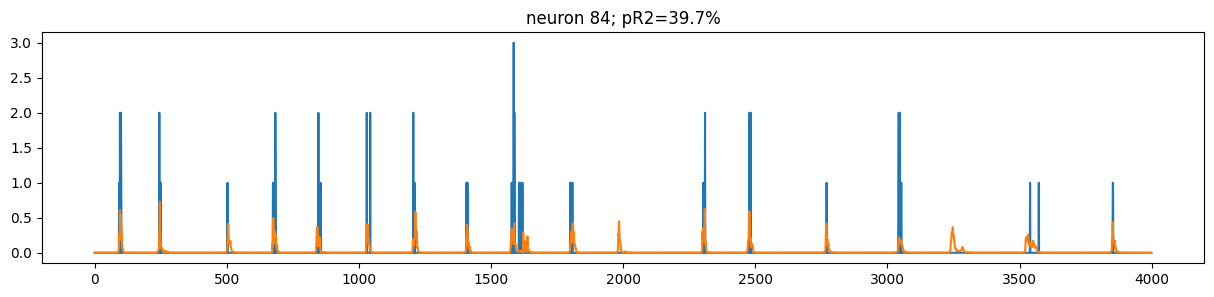

14


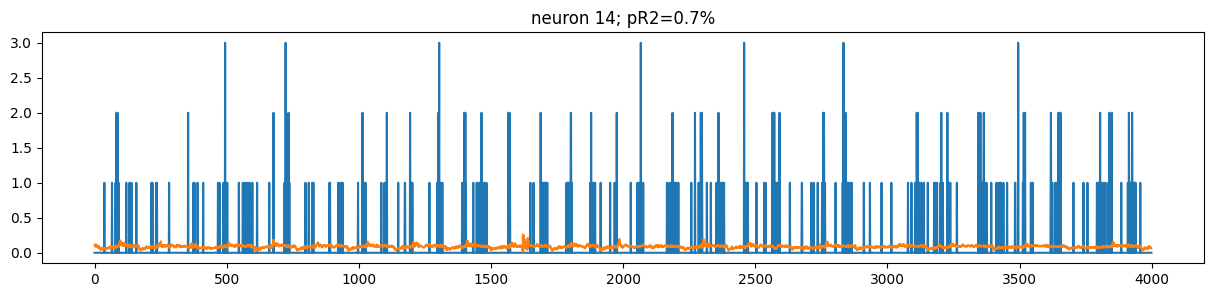

16


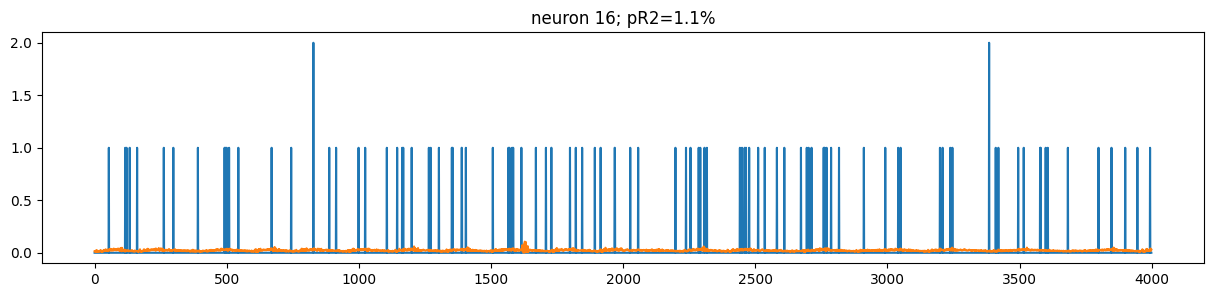

In [51]:
for neuron_id in np.argsort(-r2)[:2]:
    print(neuron_id)
    binned_spikes = data.get_neuron_spikes(neuron_id) 
    plt.figure(figsize=(15,3))
    plt.plot(binned_spikes[2000:6000])
    plt.plot(prediction[2000:6000,neuron_id])
    plt.title(f"neuron {neuron_id}; pR2={r2[neuron_id]*100:.1f}%")
    plt.show()

for neuron_id in np.argsort(r2)[:2]:
    print(neuron_id)
    binned_spikes = data.get_neuron_spikes(neuron_id) 
    plt.figure(figsize=(15,3))
    plt.plot(binned_spikes[2000:6000])
    plt.plot(prediction[2000:6000,neuron_id])
    plt.title(f"neuron {neuron_id}; pR2={r2[neuron_id]*100:.1f}%")
    plt.show()

# Optional exercise: Extending the Design Matrix to include spike history

In [52]:
def build_design_matrix_with_history(stim, spikes, filter_size, history_timesteps):
    # Build design matrix as for part I
    design_mat_stim = build_design_matrix(stim, filter_size=filter_size)

    # Build spike-history design matrix
    padded_spikes = np.hstack((np.zeros(history_timesteps), spikes_binned[:-1]))
    # SUPER important: note that this doesn't include the spike count for the
    # bin we're predicting? The spike train is shifted by one bin (back in
    # time) relative to the stimulus design matrix
    design_mat_spikes = scipy.linalg.hankel(padded_spikes[:-history_timesteps+1], padded_spikes[-history_timesteps:])

    return np.concatenate((design_mat_stim, design_mat_spikes), axis=1)

<Figure size 640x480 with 0 Axes>

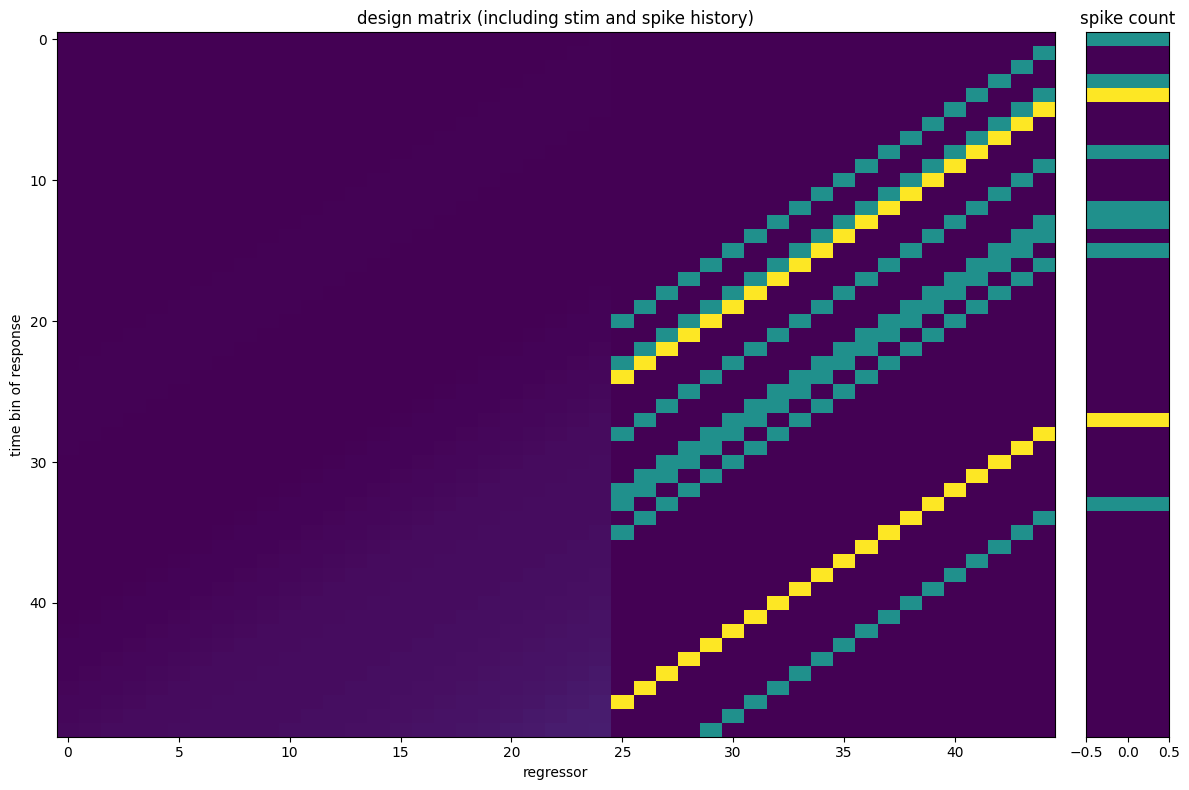

done


In [53]:
cell_idx = 51
spikes_binned = data.get_neuron_spikes(cell_idx)
stim = data.position
design_matrix = build_design_matrix_with_history(stim, spikes_binned, filter_size = 25, history_timesteps=20)

plt.clf()
fig = plt.figure(figsize=[12,8])
plt.subplot(1,10,(1,9))
plt.imshow(design_matrix[:50], aspect='auto', interpolation='nearest')
plt.xlabel('regressor')
plt.ylabel('time bin of response')
plt.title('design matrix (including stim and spike history)')
plt.subplot(1,10,10)
plt.imshow(spikes_binned[:50,np.newaxis], aspect='auto', interpolation='nearest')
plt.yticks(ticks=[], labels=[])
plt.title('spike count')
plt.tight_layout()
plt.show()

print("done")

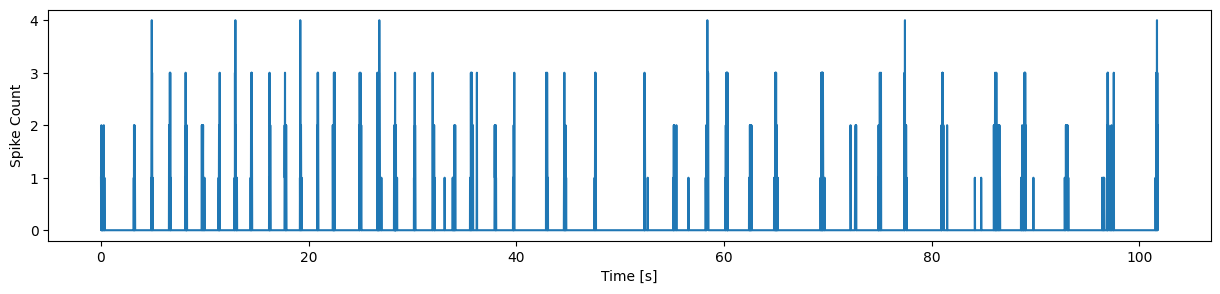

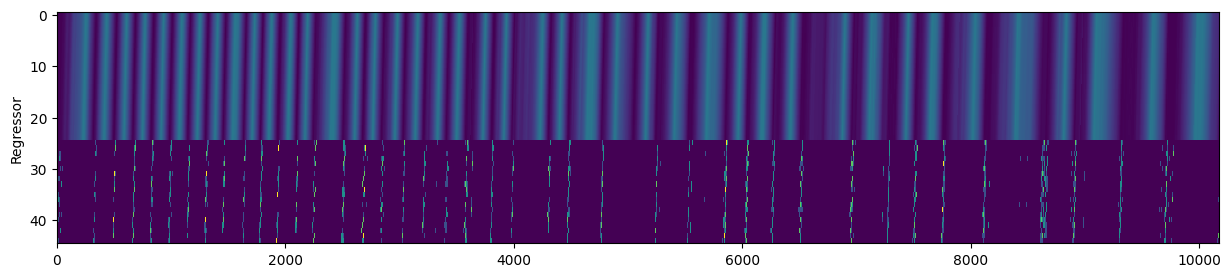

In [54]:
cell_idx = 51
spikes_binned = data.get_neuron_spikes(cell_idx)
stim = data.position
design_matrix = build_design_matrix_with_history(stim, spikes_binned, filter_size = 25, history_timesteps=20)

plt.figure(figsize=(15,3))
plt.plot(data.time, spikes_binned)
plt.xlabel("Time [s]")
plt.ylabel("Spike Count")
plt.show()

plt.figure(figsize=(15,3))
plt.imshow(design_matrix.T, aspect = "auto", interpolation="none")
plt.ylabel("Regressor")
plt.show()

Score, w/o history 0.1449798725785274
Score, w/ history  0.25723383100135844


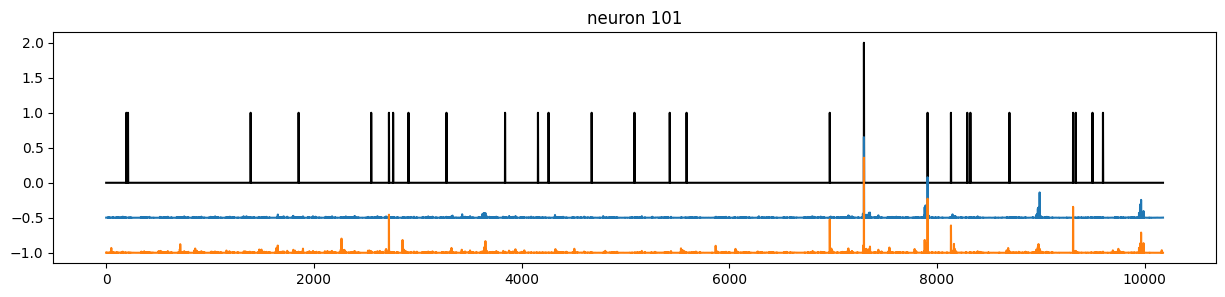

In [55]:
cell_idx = 101
spikes = data.get_neuron_spikes(cell_idx)
stim = data.position

design_matrix_standard = build_design_matrix(stim, filter_size = 50)
design_matrix_history = build_design_matrix_with_history(stim, spikes_binned, filter_size = 50, history_timesteps=50)

glm = GLMModel()
glm.fit(design_matrix_standard, spikes)
pred_wo_history = glm.predict(design_matrix_standard)
print("Score, w/o history", glm.score())

glm.fit(design_matrix_history, spikes)
pred_w_history = glm.predict(design_matrix_history)
print("Score, w/ history ", glm.score())

plt.figure(figsize=(15,3))
plt.plot(spikes, c = "black")
plt.plot(pred_wo_history - .5)
plt.plot(pred_w_history - 1.0)
plt.title(f"neuron {cell_idx}")
plt.show()